In [102]:
import pandas as pd
import seaborn as sns
import os


In [103]:
dfs = []

bench_dir = "bench/ycsb"

for store_config in os.listdir(bench_dir):
    print(f"processing {store_config}")
    parts = store_config.split(",")
    config = {}
    for part in parts:
        kv = part.split("=")
        config[kv[0]] = kv[1]


    print("config keys:", list(config.keys()))
    store = config["store"]
    tls = config["tls"] == "True"
    enclave = "sgx" if config["sgx"] == "True" else "virtual"
    worker_threads = int(config["worker_threads"])

    workload = config["workload"]
    rate = int(config["rate"])

    file = os.path.join(bench_dir, store_config, "timings.csv")
    if not os.path.exists(file):
        continue
    df = pd.read_csv(file)
    start = df["timestamp_us"].min()
    df["timestamp_us"] -= start
    df["start_ms"] = df["timestamp_us"] / 1000
    df.drop(["timestamp_us"], axis=1, inplace=True)
    df["latency_ms"] = df["latency_us"] / 1000
    df.drop(["latency_us"], axis=1, inplace=True)
    df["workload"] = workload
    df["store"] = store
    df["tls"] = tls
    df["enclave"] = enclave
    df["worker_threads"] = worker_threads
    df["rate"] = rate
    dfs.append(df)

all_data = pd.concat(dfs, ignore_index=True)
all_data.head()


processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloadc,rate=1000
config keys: ['store', 'port', 'tls', 'sgx', 'worker_threads', 'workload', 'rate']
processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloade,rate=1000
config keys: ['store', 'port', 'tls', 'sgx', 'worker_threads', 'workload', 'rate']
processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloadd,rate=1000
config keys: ['store', 'port', 'tls', 'sgx', 'worker_threads', 'workload', 'rate']
processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloadf,rate=1000
config keys: ['store', 'port', 'tls', 'sgx', 'worker_threads', 'workload', 'rate']
processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloadb,rate=1000
config keys: ['store', 'port', 'tls', 'sgx', 'worker_threads', 'workload', 'rate']
processing store=etcd,port=8000,tls=True,sgx=False,worker_threads=0,workload=workloada,rate=1000
con

,operation,start_ms,latency_ms,workload,store,tls,enclave,worker_threads,rate
0,READ,0.000,2.461,workloadc,etcd,True,virtual,0,1000
1,READ,2.466,0.369,workloadc,etcd,True,virtual,0,1000
2,READ,2.840,0.316,workloadc,etcd,True,virtual,0,1000
3,READ,3.159,0.250,workloadc,etcd,True,virtual,0,1000
4,READ,4.522,0.255,workloadc,etcd,True,virtual,0,1000


In [104]:

def merged_variable_columns_without(all_data, without):
    all_columns = list(all_data.columns)
    data_columns = ["start_ms", "start_s", "end_ms", "latency_ms"]
    # variable columns are all the ones left
    variable_columns = [c for c in all_columns if c not in data_columns]
    remaining_columns = [c for c in variable_columns if c not in without]

    def make_new_column(name):
        if name == "store":
            return all_data[name].astype(str)
        elif name == "tls":
            return all_data[name].map(lambda t: "tls" if t else "notls")
        else:
            return f"{name}=" + all_data[name].astype(str)

    invariant_columns = []
    variant_columns = []
    for c in remaining_columns:
        data = all_data[c]
        if len(set(data)) == 1:
            n = make_new_column(c)
            invariant_columns.append(n[0])
        else:
            variant_columns.append(c)

    
    variant_column = pd.Series()
    num_cols = len(variant_columns)
    for i, c in enumerate(variant_columns):
        n = make_new_column(c)
        if num_cols != i + 1:
            n = n + ","
        if i != 0:
            n = variant_column + n
        variant_column = n

    return variant_column, invariant_columns


In [105]:
os.makedirs("plots/ycsb", exist_ok=True)

/tmp/ipykernel_71984/545046243.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  variant_column = pd.Series()


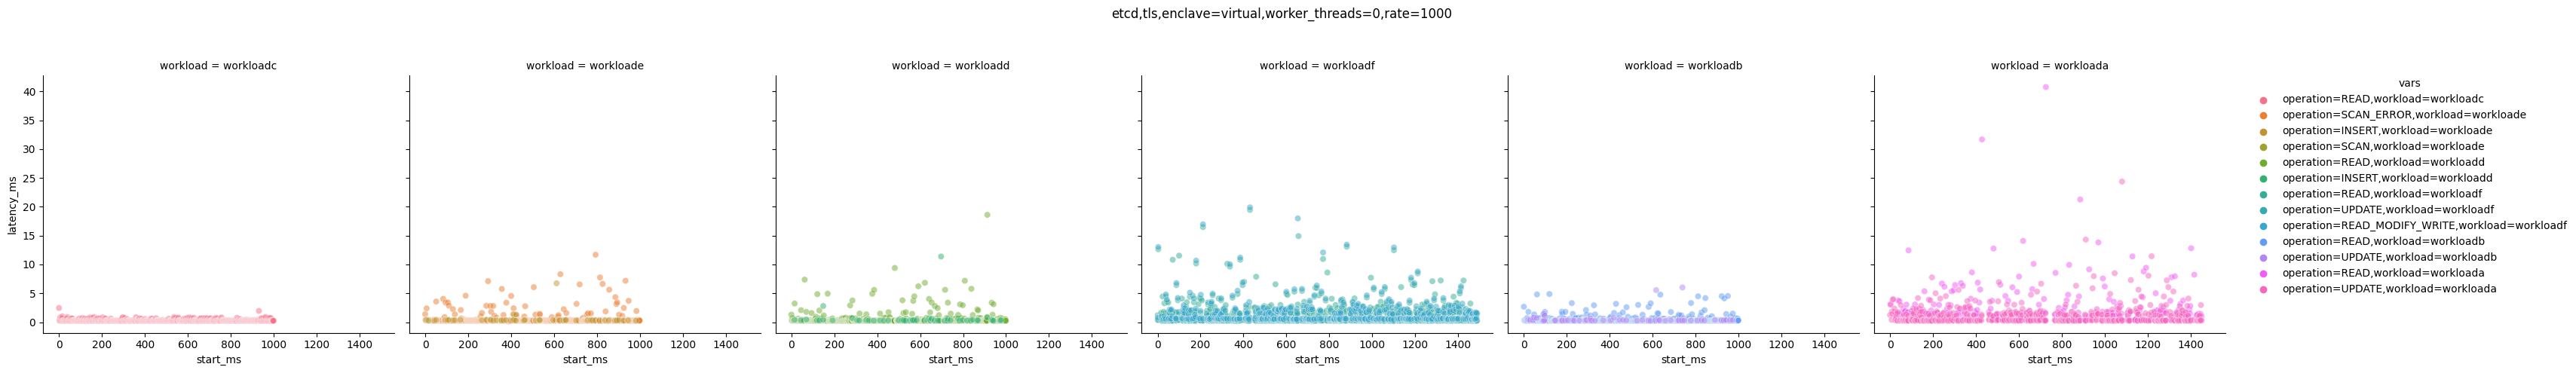

In [106]:
plot_data = all_data.copy(deep=False)
other_vars, invariant_vars = merged_variable_columns_without(
    all_data, []
)
plot_data["vars"] = other_vars

p = sns.relplot(
    kind="scatter",
    data=plot_data,
    x="start_ms",
    y="latency_ms",
    col="workload",
    hue="vars",
    alpha=0.5,
)

p.figure.subplots_adjust(top=.8)
p.figure.suptitle(",".join(invariant_vars))

# add tick labels to each x axis
for ax in p.axes.flatten():
    ax.tick_params(labelbottom=True)

#     ax.set_xlim([20,21])

p.savefig("plots/ycsb/scatter.svg")
p.savefig("plots/ycsb/scatter.jpg")


/tmp/ipykernel_71984/545046243.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  variant_column = pd.Series()


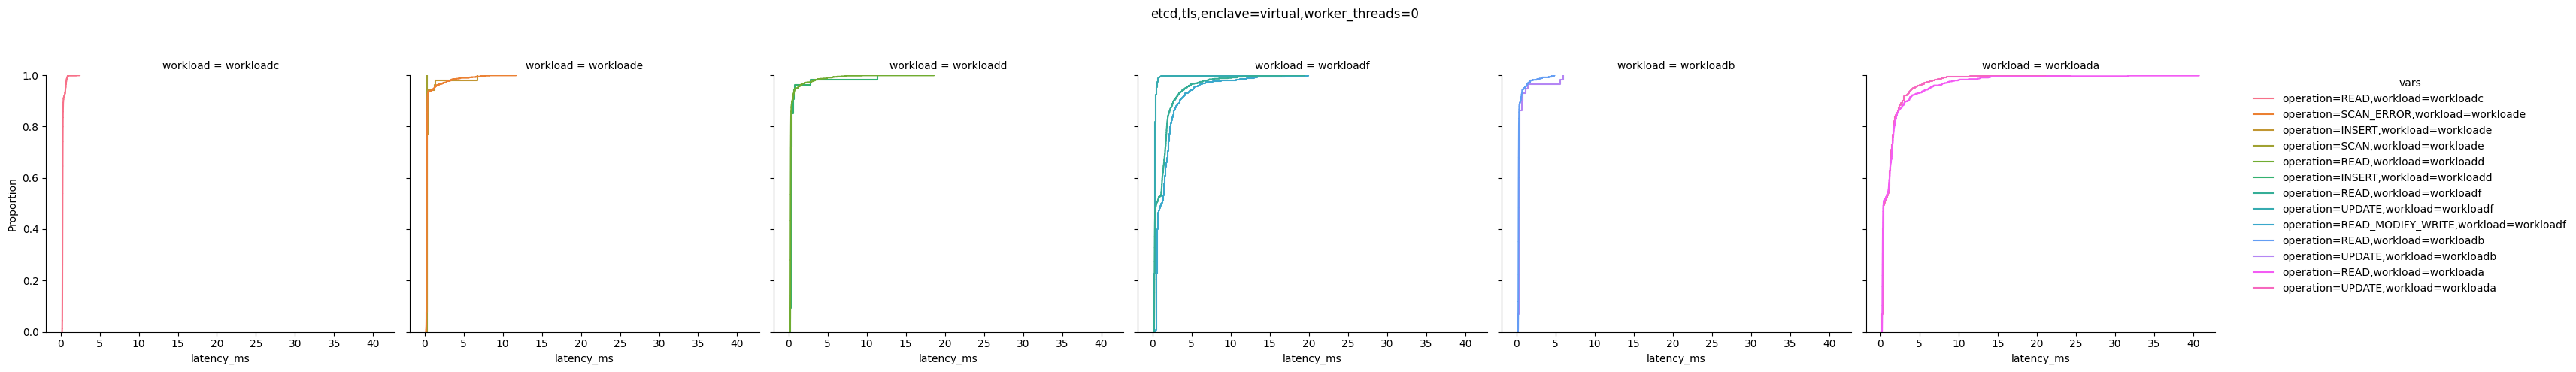

In [107]:

plot_data = all_data.copy(deep=False)
# plot_data = plot_data[plot_data["cmd"] == "put"]
plot_data["vars"], invariant_vars = merged_variable_columns_without(
    all_data, ["rate", "prefill_num_keys"]
)

p = sns.displot(
    kind="ecdf",
    data=plot_data,
    x="latency_ms",
    col="workload",
    hue="vars",
)

p.figure.subplots_adjust(top=.8)
p.figure.suptitle(",".join(invariant_vars))

# add tick labels to each x axis
for ax in p.axes.flatten():
    ax.tick_params(labelbottom=True)

p.savefig("plots/ycsb/ecdf.svg")
p.savefig("plots/ycsb/ecdf.jpg")

/tmp/ipykernel_71984/545046243.py:27: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  variant_column = pd.Series()


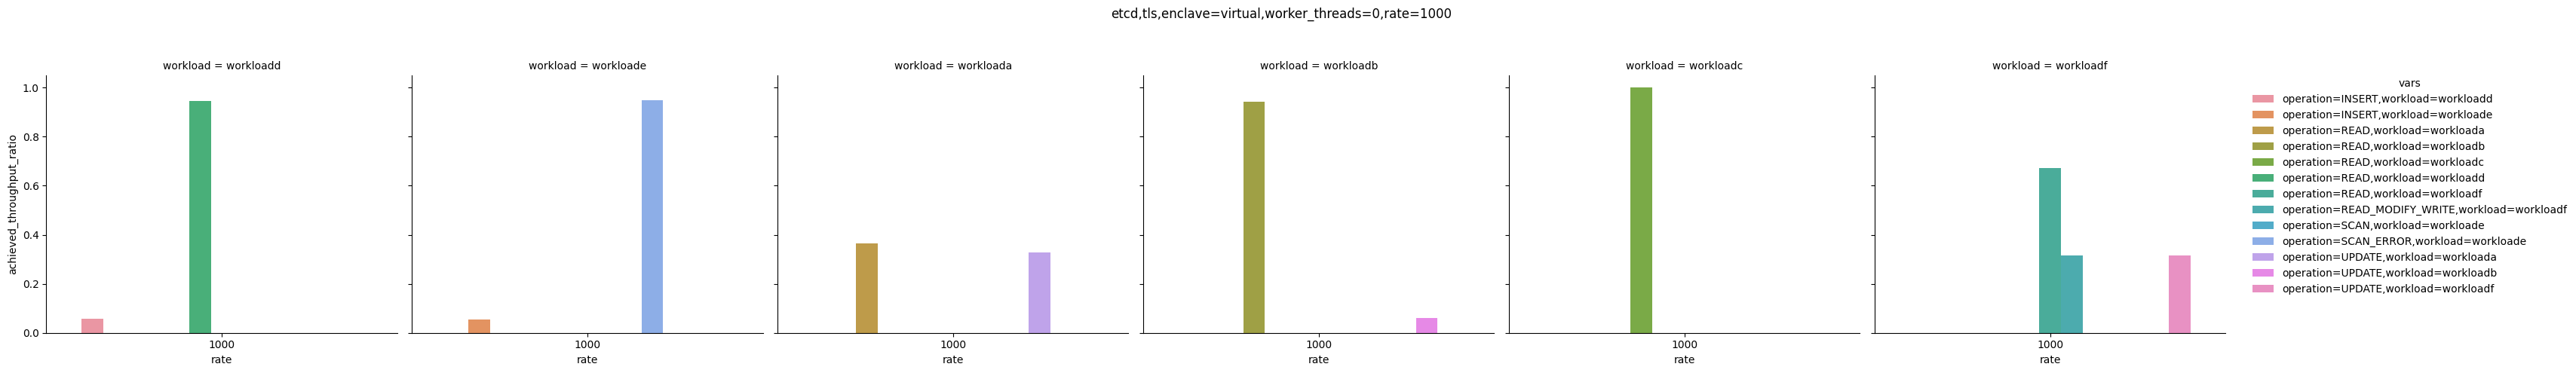

In [109]:
plot_data = all_data.copy(deep=False)
plot_data["vars"], invariant_vars = merged_variable_columns_without(
    all_data, []
)

grouped = plot_data.groupby(["vars"])
throughputs = grouped.first()

durations = (grouped["start_ms"].max() - grouped["start_ms"].min()) / 1000
counts = grouped["start_ms"].count()
achieved_throughput = counts / durations
throughputs["achieved_throughput_ratio"] = achieved_throughput / throughputs["rate"]

throughputs.reset_index(inplace=True)

p = sns.catplot(
    kind="bar",
    data=throughputs,
    x="rate",
    y="achieved_throughput_ratio",
    col="workload",
    hue="vars",
)

p.figure.subplots_adjust(top=.8)
p.figure.suptitle(",".join(invariant_vars))

# add tick labels to each x axis
for ax in p.axes.flatten():
    ax.tick_params(labelbottom=True)

p.savefig("plots/ycsb/throughput.svg")
p.savefig("plots/ycsb/throughput.jpg")
